# What is this

Questo documento rappresenta un template per le analisi.

Dovrà essere tenuto aggiornato seguendo le convenzioni utilizzate da **runner** per l'organizzazione  dei file e delle directory di input e output

# TODO

 - **Fitness media nel tempo dei run definitivi**
 - Quali modelli sono stati usati di più, in media? -> Prodotto da runner
 - Fitness media dei modelli? (non credo di avere questa info) TODO non mi è chiaro

In [1]:
# Change the width of the notebook cell, for a better use of space
from IPython.core.display import display, HTML
display(HTML("<style>.container { min-width: 900px;}</style>"))

In [2]:
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
def parse_duration(s):
    """Parse golang duration string.
    
    Parse a string of a Golang duration into
    a float representing seconds.
    """
    import re
    s = s.strip()

    # Tuples pattern-multiplier(s)
    patterns = [
        ('(0)s', 1,),
        ('(\\d+)ns', 1e-9,),
        ('(\\d+\\.\\d+)ns', 1e-9,),
        ('(\\d+)µs', 1e-6,),
        ('(\\d+\\.\\d+)µs', 1e-6,),
        ('(\\d+)ms', 1e-3,),
        ('(\\d+\\.\\d+)ms', 1e-3,),
        ('(\\d+)s', 1,),
        ('(\\d+\\.\\d+)s', 1,),
        ('(\\d+)m(\\d+)s', 60, 1),
        ('(\\d+)m(\\d+\\.\\d+)s', 60, 1),
        ('(\\d+)h(\\d+)s', 3600, 1),
        ('(\\d+)h(\\d+\\.\\d+)s', 3600, 1),
        ('(\\d+)h(\\d+)m(\\d+)s', 3600, 60, 1),
        ('(\\d+)h(\\d+)m(\\d+\\.\\d+)s', 3600, 60, 1),
    ]
    for p, *x in patterns:
        m = re.match(p+'$', s, flags=re.ASCII)
        if m is not None:
            tot = 0
            for g, multiplier in enumerate(x, 1):
                tot += float(m.group(g)) * multiplier
            return tot
    return float(s) * 0.001 # Try matching a pure number of mulliseconds


def load_test(path, cv_runs=30):
    """Load CV data of a single run.
    
    Given path of a single run, load the data files
    in it and returns the average values after CV.
    
    Returns average fitness for training and testing,
    and average running times.
    """
    fit_test = []
    fit_train = []
    timing = []

    for p in range(cv_runs):        
        ftp = os.path.join(path, f'fit_train_{p}.txt')
        ft = pd.read_table(ftp, names=['fit'], header=None)
        fit_train.append(ft.values)
        
        ftp = os.path.join(path, f'fit_test_{p}.txt')
        ft = pd.read_table(ftp, names=['fit'], header=None)
        fit_test.append(ft.values)

        tp = os.path.join(path, f'timing{p}.txt')
        with open(tp) as tpf:
            timing.append([parse_duration(l.strip()) for l in tpf])
    
    fit_train = np.array(fit_train).mean(axis=0)
    fit_test = np.array(fit_test).mean(axis=0)
    timing = np.array(timing).mean(axis=0)

    fit_train = np.minimum(fit_train, 1000)
    fit_test = np.minimum(fit_test, 1000)
    
    return fit_train, fit_test, timing


def load_block_results(prefix, block, count, cv_splits=30):
    """Loads the data from the specified directory.
    
    Prefix is a directory containing the simulation prefix. Inside directory
        /some/path/prefix
    there will be directories named prefix0, prefix1, ... prefixN.
    Each of these, will contain a "block" directory with the CV runs.
    This function loads the CV runs in those blocks, for all the N runs.
    """
    cpu_train, cpu_test, cpu_timing = [], [], []

    name = os.path.basename(prefix)
    for i in range(count):
        block_path = os.path.join(prefix, f'{name}{i}', block)
        train, test, timing = load_test(block_path, cv_splits)
        cpu_train.append(train)
        cpu_test.append(test)
        cpu_timing.append(timing)

    cpu_data = [
        np.array(cpu_train).mean(axis=0),
        np.array(cpu_test).mean(axis=0),
        np.array(cpu_timing).mean(axis=0),
    ]

    return cpu_data

def load_all_results(prefix, count, cv_splits=30):
    """Loads all the blocks data from the specified directory.
    
    Prefix is a directory containing the simulation prefix. Inside directory
        /some/path/prefix
    there will be directories named prefix0, prefix1, ... prefixN.
    Each of these, will contain a directory selection and a directory
    longrun with the CV runs.
    """
    
    selection_data = load_block_results(prefix, 'selection', count, cv_splits)
    longrun_data = load_block_results(prefix, 'longrun', count, cv_splits)
    return selection_data, longrun_data

# Analisi Dati

Le analisi fatte qui sono comparative: specificando un insieme di directory di output, il resto del notebook farà un'analisi di quei dati e mostrerà i risultati.

In [19]:
# Where data files are stored
out_dir = 'lollethai'



In [20]:
import json
with open(os.path.join(out_dir, 'stats.json')) as statsfile:
    stats = json.load(statsfile)
print(stats)

{'args': {'all': False, 'k_fold': 3, 'runs': 4, 'shortg': 1, 'longg': 5}, 'models': ['nl_mlp_sem', 'nl_lr_sem', 'nl_svr_sem'], 'models2': [[], ['nl_mlp_sem'], ['nl_lr_sem'], ['nl_svr_sem'], ['nl_mlp_sem', 'nl_lr_sem'], ['nl_mlp_sem', 'nl_svr_sem'], ['nl_lr_sem', 'nl_svr_sem'], ['nl_mlp_sem', 'nl_lr_sem', 'nl_svr_sem']], 'n_runs': 4, 'k_fold': 3, 'configuration.ini': 'population_size\t= 200\nmax_number_generations = 300\ninit_type = 2\n# p_crossover = 0.0\n# p_mutation = 1.0\nmax_depth_creation = 6\ntournament_size\t= 4\nzero_depth = 0\nmutation_step = 1\nnum_random_constants = 0\nmin_random_constant = -100\nmax_random_constant = 100\nminimization_problem = 1\n', 'sel_time': 97.7028349040047, 'sel_times': [29.750743937998777, 22.59337911500188, 22.276852009999857, 23.08185984100419], 'best_models': {'4': 1, '1': 1, '7': 2}, 'lon_time': 19.550659287997405, 'lon_times': [4.1277414220021456, 2.2072398659947794, 6.755444294998597, 6.460233705001883]}


## Vecchie analisi di paragone: FIXME

In [14]:
old_data_path = '/home/akiross/Simulazioni_domani/Simulations/cemento/cpu_data.pkl'
with open(old_data_path, 'rb') as pif:
    old_data = pickle.load(pif)

if True:
    new_data = load_all_results('./cemeprova', 2, 3)
    with open('./cpu_data.pkl', 'wb') as pof:
        pickle.dump(new_data, pof)
else:
    with open('./cpu_data.pkl', 'rb') as pif:
        new_data = pickle.load(pif)

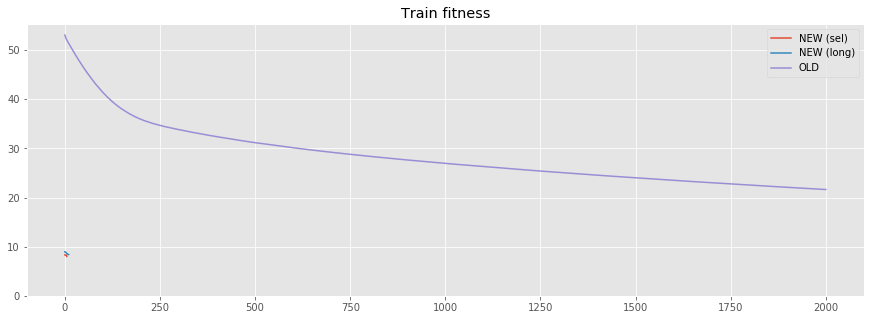

In [17]:
plt.figure()#subplot(1, 3, 1)
plt.title('Train fitness')
plt.plot(new_data[0][0])
plt.plot(new_data[1][0])
plt.plot(old_data[0])
plt.legend(['NEW (sel)', 'NEW (long)', 'OLD'])
plt.ylim(ymin=0)

if False:
    plt.figure()#subplot(1, 3, 2)
    plt.title('Test fitness')
    plt.plot(new_data[1])
    plt.plot(old_data[1])
    plt.legend(['NEW', 'OLD'])
    plt.ylim(ymin=0)

    plt.figure()#subplot(1, 3, 3)
    plt.title('Runtime')
    plt.plot(new_data[2])
    plt.plot(old_data[2])
    plt.legend(['NEW', 'OLD'])
    plt.ylim(ymin=0)

    plt.figure()
    plt.title('Runtime-vs-fitness (train)')
    plt.plot(new_data[2], new_data[0])
    plt.plot(old_data[2], old_data[0])
    plt.legend(['NEW', 'OLD'])
    plt.ylim(ymin=0)

    plt.figure()
    plt.title('Runtime-vs-fitness (test)')
    plt.plot(new_data[2], new_data[1])
    plt.plot(old_data[2], old_data[1])
    plt.legend(['NEW', 'OLD'])
    plt.ylim(ymin=0)

## Train vs Test

 - Siamo sicuri che i dati non siano gli stessi?
 - C'é overfitting?

(0, 8.5064936836658394)

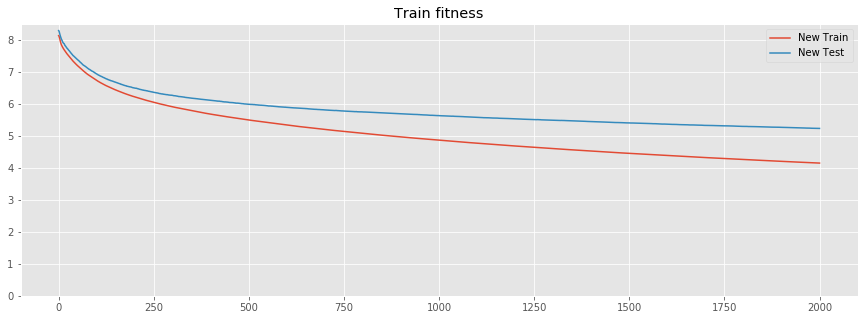

In [5]:
plt.figure()
plt.title('Train fitness')
plt.plot(new_data[0])
plt.plot(new_data[1])
plt.legend(['New Train', 'New Test'])
plt.ylim(ymin=0)

# Statistics

## Running time
Pie chart with running time (selection-vs-longrun)

Total running time for 2 runs: (40.86770571499983, 7.114737427998989)


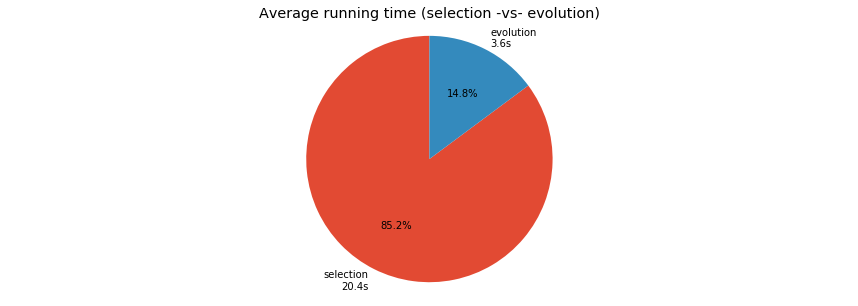

In [6]:
runtimes = stats['sel_time'], stats['lon_time']
labels = [f'selection\n{runtimes[0]/stats["n_runs"]:.1f}s', f'evolution\n{runtimes[1]/stats["n_runs"]:.1f}s']

fig, ax = plt.subplots()
ax.pie([r for r in runtimes], labels=labels, autopct='%1.1f%%', startangle=90)
# Plot as a circle
ax.axis('equal')
ax.set_title('Average running time (selection -vs- evolution)')
print(f'Total running time for {stats["n_runs"]} runs: {runtimes}')

## Best model selection frequency

We want to see how often models are selected for seeding.

Best models freq
{'4': 2}


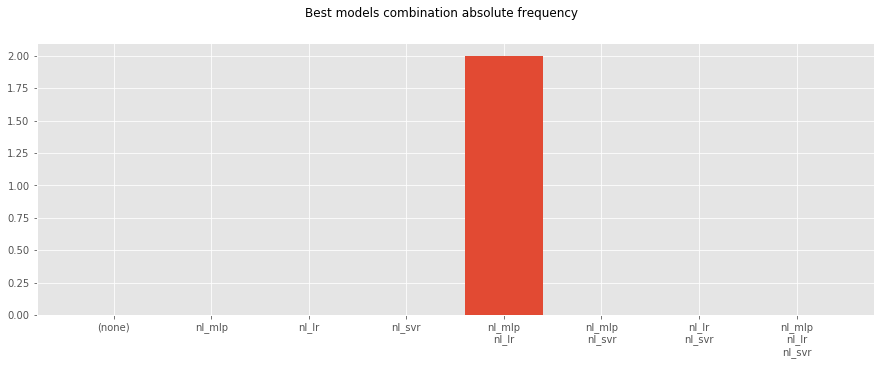

In [7]:
# Best model frequency
bm = stats['best_models']
# Models combinations
mc = stats['models2']
# Number of combinations
nm = len(mc)

# Remove possible suffix _sem from model names
mc = [[s.rsplit('_sem', 1)[0] for s in m] for m in mc]

# Prepare data for plotting
x = list(range(nm))
h = [bm.get(str(i), 0) for i in range(nm)]

# Prepare bar chart
fig, ax = plt.subplots()
ax.bar(x, h)

# Write models in column
labels = ['\n'.join(m) if m else '(none)' for m in mc]
ax.set_xticks(range(nm))
ax.set_xticklabels(labels)

# Set title
fig.suptitle('Best models combination absolute frequency')

print('Best models freq')
print(bm)

## Evolution of semantic distance

We get from the models the best semantic. We want to see how the distance between the semantic of the best model and the semantic of the best individual evolve.

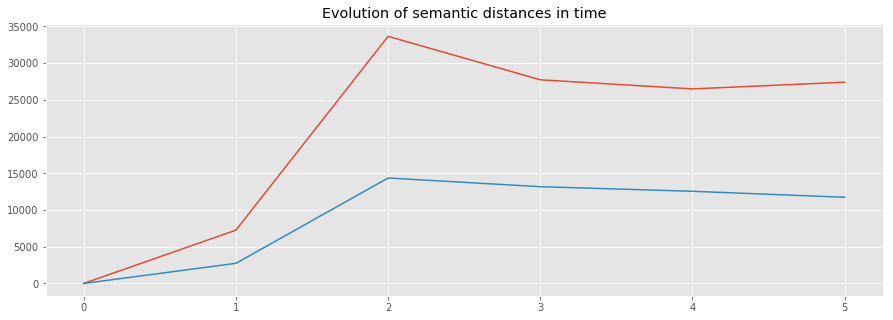

In [23]:
def load_semantic_avg(name, run, dataset):
    """Return the average semantic from the specified longrun."""
    return np.loadtxt(f'{name}/{name}{run}/longrun/sem_{dataset}_avg.txt')

def load_sem_distance_avg(name, run, dataset):
    """Return the first-last semantic distance for the specified run."""
    sem = load_semantic_averages(name, run, dataset)
    sd = (sem - sem[0]) ** 2
    return sd.sum(axis=1)  # Sum along rows

def load_avg_sem_distance_avg(name, n_runs, dataset):
    """Computes average semantic distance for specified dataset."""
    tot = load_sem_distance_avg(name, 0, dataset)
    for i in range(1, n_runs):
        tot += load_sem_distance_avg(name, i, dataset)
    return tot / n_runs




def semantic_distance(s1, s2):
    """Compute L2-norm between two semantics."""
    return sum((s1 - s2) ** 2)

def load_semantic(name, run, fold, dataset):
    """Return the semantic from the specified fold in a longrun."""
    sem = []
    with open(f'{name}/{name}{run}/longrun/sem_{dataset}_{fold}.txt', 'rt') as fp:
        for l in fp:
            sem.append(np.array([float(v) for v in l.split(',')]))
    return sem

def load_sem_distance(name, run, fold, dataset):
    """Load the k-fold semantic and compute distance among first semantic and all the others, returning it."""
    sem = load_semantic(name, run, fold, dataset)
    return [semantic_distance(sem[0], s) for s in sem]

def load_folded_sem_distance(name, run, n_folds, dataset):
    """Return the k-fold average of semantic distance."""
    # Load semantic of
    dist = np.array(load_sem_distance(name, run, 0, dataset))
    # Compute average distances
    for i in range(1, n_folds):
        dist += np.array(load_sem_distance(name, run, i, dataset))
    return dist / n_folds

def load_avg_sem_distance(name, n_runs, n_folds, dataset):
    """Return the total average of semantic distance."""
    dist = sum(load_folded_sem_distance(name, r, n_folds, dataset) for r in range(n_runs))
    return dist / n_runs

sem_evo_train = load_avg_sem_distance_avg(out_dir, stats['args']['runs'], 'train')
sem_evo_test = load_avg_sem_distance_avg(out_dir, stats['args']['runs'], 'test')

# Load the average semantic
# = load_avg_sem_distance(out_dir, 10, 5, 'train')
#sem_evo_test = load_avg_sem_distance(out_dir, 10, 5, 'test')

fig, ax = plt.subplots(1, 1)
ax.plot(sem_evo_train)
ax.plot(sem_evo_test)
ax.set_title('Evolution of semantic distances in time')